In [1]:
import numpy as np
import pandas as pd
import torch

import warnings
warnings.filterwarnings("ignore")

# Data exploration

In [110]:
df = pd.read_csv("data/rookie_df.csv", low_memory=False)
df

,Unnamed: 0,Year Drafted,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,target
0,0,2013,70,34.5,16.7,6.1,15.1,40.5,0.8,3.0,...,70.3,1.4,4.8,6.2,6.3,1.9,0.6,3.5,17.6,1
1,1,2013,70,32.3,12.8,4.9,12.8,38.0,1.6,4.8,...,90.3,0.5,2.4,3.0,5.7,0.6,0.1,1.9,12.1,1
2,2,2013,80,31.1,13.8,4.9,11.7,41.9,0.9,2.8,...,78.0,0.5,3.6,4.1,4.1,1.6,0.5,3.2,13.2,1
3,3,2013,82,26.7,8.8,3.1,8.3,37.6,1.2,3.6,...,80.4,0.6,2.2,2.9,1.0,0.6,0.2,1.2,6.7,1
4,4,2013,77,24.6,6.8,2.2,5.4,41.4,0.5,1.5,...,68.3,1.0,3.4,4.4,1.9,0.8,0.8,1.6,9.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,1419,1980,59,10.1,3.2,1.4,3.1,45.4,0.0,0.1,...,56.4,0.5,0.6,1.0,1.2,0.6,0.1,1.3,2.8,0
1420,1420,1980,47,9.6,2.0,0.7,2.0,35.8,0.0,0.1,...,78.1,0.2,0.7,0.9,1.5,0.5,0.0,0.6,2.9,1
1421,1421,1980,60,8.9,2.8,1.0,3.0,33.0,0.0,0.1,...,73.9,0.5,0.7,1.2,1.3,0.4,0.0,0.6,2.7,0
1422,1422,1980,55,8.4,2.7,1.0,2.5,41.2,0.0,0.1,...,43.5,0.5,1.2,1.7,0.3,0.4,0.4,0.6,2.6,0


In [111]:
df.columns

Index(['Unnamed: 0', 'Year Drafted', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%',
       '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'EFF', 'target'],
      dtype='object')

### Biranje atributa [DEPRICATED]

U datasetu postoje 66 atributa za svakog igrača, što je previše. Redukcija prostora atributa će biti vršena u tri koraka:

1. Izbacivanje redundantnih atributa.  _Primer_: Odnos asistencija i izgubljenih lopti (`ast/tov`) je suvišan kada već postoje atributi za broj asistencije i broj izgubljenih lopti
2. Izbacivanje atributa na osnovu iskustvenog zananja. _Primer_: Nepotrebno je da pored škole za koju igra student koristimo kao atribut i konferenciju u kojoj je ta škola
3. Nad ostalim atributima će biti izračunata korelacija sa ciljanim izlazima modela, i biće izabrani najboljih 10

Ovim postupkom će model biti manji, i samim tim će mu biti smanjena mogućnost overfittovanja.

Cilj mreže je predviđanje da li će neki pik biti izabran na draftu. Svi odbirci koji imaju vrednost u `pick` koloni biće označeni kao pozitivni, dok će ostali biti označeni kao negativni

In [112]:
# Choose valuable features
clean_df = df[['GP', 'MIN', 'PTS', 'FGM', 'FGA',
       '3P Made', '3PA', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'EFF', 'target']].copy()
clean_df.dropna(inplace=True)

In [113]:
# Describe features
clean_df.describe()

,GP,MIN,PTS,FGM,FGA,3P Made,3PA,FTM,FTA,OREB,DREB,AST,STL,BLK,TOV,EFF,target
count,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000
mean,61.131320,17.483216,6.735323,2.602247,5.799930,0.238062,0.740520,1.295084,1.822121,1.034059,2.041011,1.497331,0.601826,0.388764,1.188062,7.381461,0.601124
std,16.828774,8.265126,4.324453,1.666493,3.545943,0.385139,1.057448,0.981904,1.322281,0.786525,1.371742,1.445766,0.406427,0.471463,0.714481,4.621797,0.489839
min,11.000000,3.100000,0.700000,0.300000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.200000,0.000000
25%,48.000000,10.900000,3.600000,1.400000,3.200000,0.000000,0.000000,0.600000,0.900000,0.500000,1.000000,0.500000,0.300000,0.100000,0.700000,3.800000,0.000000
50%,64.000000,15.950000,5.500000,2.100000,4.800000,0.000000,0.200000,1.000000,1.500000,0.800000,1.700000,1.000000,0.500000,0.200000,1.000000,6.350000,1.000000
75%,77.000000,23.000000,8.800000,3.400000,7.500000,0.300000,1.100000,1.700000,2.300000,1.400000,2.700000,1.900000,0.800000,0.500000,1.500000,9.800000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,2.300000,6.500000,7.700000,10.200000,5.400000,9.600000,10.600000,2.500000,5.000000,4.400000,30.600000,1.000000


In [117]:
# Calculate percentage of True datapoints
value_cnts = clean_df["target"].value_counts()
print(f"Dataset sadrži {len(clean_df)} odbiraka, od čega su {value_cnts[1] / len(clean_df) * 100:0.2f}% pozitivni na koronu/COVID-19/Komunjarski Grip.")

Dataset sadrži 1424 odbiraka, od čega su 60.11% pozitivni na koronu/COVID-19/Komunjarski Grip.


In [116]:
clean_df.corr()

,GP,MIN,PTS,FGM,FGA,3P Made,3PA,FTM,FTA,OREB,DREB,AST,STL,BLK,TOV,EFF,target
GP,1.000000,0.616953,0.546825,0.548465,0.526646,0.147552,0.145556,0.484857,0.478958,0.398580,0.480485,0.368997,0.466951,0.279178,0.514329,0.587754,0.355453
MIN,0.616953,1.000000,0.912241,0.904418,0.909564,0.376451,0.391687,0.797597,0.786574,0.581778,0.746446,0.621459,0.749358,0.402372,0.831197,0.919360,0.343364
PTS,0.546825,0.912241,1.000000,0.991004,0.979798,0.350964,0.364142,0.898805,0.882213,0.570365,0.688916,0.549174,0.675042,0.369685,0.852544,0.918183,0.341491
FGM,0.548465,0.904418,0.991004,1.000000,0.980419,0.293704,0.307220,0.852244,0.844285,0.591429,0.697721,0.529818,0.663217,0.381845,0.837325,0.916193,0.338044
FGA,0.526646,0.909564,0.979798,0.980419,1.000000,0.390767,0.416726,0.830208,0.808708,0.500348,0.633550,0.588603,0.690498,0.307485,0.848098,0.866277,0.335628
3P Made,0.147552,0.376451,0.350964,0.293704,0.390767,1.000000,0.984239,0.159433,0.090869,-0.223534,0.000568,0.381273,0.303313,-0.177219,0.253993,0.193161,0.151678
3PA,0.145556,0.391687,0.364142,0.307220,0.416726,0.984239,1.000000,0.176230,0.105726,-0.234178,-0.003879,0.417310,0.336437,-0.189887,0.281141,0.195245,0.156990
FTM,0.484857,0.797597,0.898805,0.852244,0.830208,0.159433,0.176230,1.000000,0.979712,0.586611,0.660995,0.471944,0.602104,0.396814,0.810107,0.854608,0.295587
FTA,0.478958,0.786574,0.882213,0.844285,0.808708,0.090869,0.105726,0.979712,1.000000,0.660766,0.710892,0.420582,0.578962,0.463894,0.804492,0.860014,0.277605
OREB,0.398580,0.581778,0.570365,0.591429,0.500348,-0.223534,-0.234178,0.586611,0.660766,1.000000,0.846181,-0.020493,0.281218,0.653881,0.433956,0.737635,0.165886


In [96]:
cov_mat = clean_df.corr().to_numpy()[:-1, :-1]

# Calculate eig
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

# Sort indexes

# Take vector subset
num_of_components = 5
eigv_subset = eigen_vectors[:, -num_of_components:]

# # Reduce X
# X_reduced = np.dot(eigv_subset.T, X.T).T

In [97]:
X = clean_df.to_numpy()[:, :-1]

X_reduced = np.dot(eigv_subset.T, X.T).T
X_reduced.shape

(61016, 5)

In [99]:
reduced_df = pd.DataFrame(X_reduced, columns=[f"f{idx}" for idx in range(num_of_components)])
reduced_df["Target"] = clean_df["Target"]
reduced_df

,f0,f1,f2,f3,f4,Target
0,-0.151748,0.426638,0.270746,1.098903,0.222516,False
1,0.097561,0.483462,0.066349,0.8777,-1.466385,False
2,0.69801,0.203203,0.926932,0.920432,-1.439232,False
3,-0.583241,0.251604,0.013704,0.68152,-0.660514,False
4,0.660798,-0.877505,-0.216661,-0.436325,-0.961933,False
...,...,...,...,...,...,...
61011,-6.213614,4.241152,6.932279,-3.721636,2.765088,False
61012,-0.05206,-0.436786,0.243023,0.42146,6.650603,False
61013,1.122304,3.291919,0.131148,-0.250891,6.428082,False
61014,1.056305,3.479652,0.150621,-0.385733,6.255471,False


## Podela na trening i test

In [205]:
from sklearn.model_selection import train_test_split

# Do train/test split
train_df, valid_df = train_test_split(clean_df, train_size=.7, random_state=420)

### Normalizacija dataset

In [280]:
from sklearn.preprocessing import StandardScaler

input_columns = clean_df.columns[:-1]

# Fit scaler
scaler = StandardScaler()
scaler.fit(train_df[input_columns].values)

# Normalize train data
norm_train_np = scaler.transform(train_df[input_columns].values)
norm_train_df = pd.DataFrame(norm_train_np, columns=input_columns)
norm_train_df["target"] = train_df["target"].values

# Normalize validation data
norm_valid_np = scaler.transform(valid_df[input_columns])
norm_valid_df = pd.DataFrame(norm_valid_np, columns=input_columns)
norm_valid_df["target"] = valid_df["target"].values

# Definisanje modela

Model će se sastojati od duboke neuronske mreže, sa potpuno povezanim slojevima.
Ulaz u mrežu će biti prethodno izabrani atributi, a izlaz će sadžati jedan neuron čiji izlaz predstavlja uverenost modela da će ulazni igrač biti NBA pik.

#### Dataset klasa

Prvi korak predstavlja definisanje klase koja će dohvatati podatke u _batch_-evima tokom treniranja.

In [123]:
from torch.utils.data import Dataset, DataLoader

class NBA_Dataset(Dataset):
    """Class for holding data of NCAA players and if there were picked for the NBA."""

    def __init__(self, df: pd.DataFrame) -> None:
        """Initialize torch Dataset based on pandas Dataframe."""
        super(NBA_Dataset, self).__init__()

        # Take all except the last column as inputs
        self.inputs = df.values[:, :-1].astype(float)

        # Cast Targets column to numpy
        self.targets = df["target"].values.astype(int)

        # Save dataframe as part of the class
        self.df = df

        # Define dataset length
        self.len = len(df)

    def __getitem__(self, index) -> dict:
        """Return dict with information of datapoint at `index`"""
        # Get input
        input_row = torch.Tensor(self.inputs[index, :])

        # Get output
        target = torch.Tensor([self.targets[index]])

        return {
            "Inputs": input_row,
            "Targets": target,
        }

    def __len__(self):
        """Get dataset length."""
        return self.len

#### Definicija modela

**OVDE SE PISE O TOME STA SVE IMA U MODELU**

In [120]:
import torch.nn as nn

class NBA_Draft_Predictor(nn.Module):
    """Class for prediction NCAA player chances of being piked in NBA draft."""

    def __init__(self, layer_sizes: list, activation_function: nn.Module = None) -> None:
        """Initialize fully-connected model based on input parameters."""
        super(NBA_Draft_Predictor, self).__init__()

        assert len(layer_sizes)

        # Check if activation function is not defined
        if activation_function is None:
            activation_function = nn.ReLU()

        # Define activation function
        self.activation = activation_function

        # Layers init
        layer_list = []

        # Define layer sizes
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer_list.append(nn.Linear(in_size, out_size))
            # layer_list.append(nn.Tanh())

        # Cast layer list to nn.Module
        self.fc_layers = nn.ModuleList(layer_list)

    def forward(self, X) -> torch.Tensor:
        """Define network behavior when called on data."""
        # Pass data trough fully-connected layers
        for layer in self.fc_layers:
            X = layer(X)
        
        # Calculate output probability as sigmoid of output
        output_probability = torch.sigmoid(X)

        return output_probability

# Trening

In [369]:
train_dataset = NBA_Dataset(train_df)

train_parameters = {
    "batch_size": 128,
    "shuffle": True,
    "num_workers": 1,
}

training_loader = DataLoader(train_dataset, **train_parameters)

# Validation dataset
valid_dataset = NBA_Dataset(valid_df)

valid_parameters = {
    "batch_size": 128,
    "shuffle": False,
    "num_workers": 1,
}

validation_loader = DataLoader(valid_dataset, **valid_parameters)

#### Inicijalizacija treninga

**Ovde objasniti zasto smo odabrali Adam optimajzer i BCE loss funkciju**

In [390]:
from torch.nn import BCELoss, CrossEntropyLoss
from torch.optim import Adam, SGD

# Initialize optimizer
model = NBA_Draft_Predictor([train_dataset.inputs.shape[1], 20, 4, 1])

# Initialize loss function as Binary Cross Entropy
loss_function = BCELoss()

# Define learning rate
lr = 8e-4

# Init Adam optimizer
optimizer = Adam(params=model.parameters(), lr=lr)

# Classification threshold
CLASS_THR = .5

In [391]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

num_of_epochs = 200

training_loss = []
training_acc = []

validation_loss = []
validation_prec = []
validation_rec = []
validation_f1 = []

validation_acc = []

for epoch in range(1, num_of_epochs + 1):

    # Run epoch of training
    train_epoch_loss = 0

    model.train()

    epoch_predictions = []
    epoch_targets = []

    for batch in training_loader:
        
        # Load batch
        X = batch["Inputs"]
        Y = batch["Targets"]

        optimizer.zero_grad()

        # Run forward pass
        probabilities = model(X)

        # Calculate loss
        loss = loss_function(probabilities, Y)
        train_epoch_loss += loss.item()

        # Update model
        loss.backward()
        optimizer.step()

        # Calculate predictions
        predictions = probabilities >= CLASS_THR

        # Log predictions
        epoch_predictions.extend(predictions.tolist())
        epoch_targets.extend(Y.tolist())

    train_epoch_loss /= len(training_loader)

    training_loss.append(train_epoch_loss)
    training_acc.append(accuracy_score(epoch_targets, epoch_predictions))

    # VALIDATION
    valid_epoch_loss = 0

    model.eval()

    epoch_predictions = []
    epoch_targets = []

    for batch in validation_loader:
        
        # Load batch
        X = batch["Inputs"]
        Y = batch["Targets"]

        # Run forward pass
        probabilities = model(X)

        # Calculate loss
        loss = loss_function(probabilities, Y)
        valid_epoch_loss += loss.item()

        # Update model
        loss.backward()

        # Calculate predictions
        predictions = probabilities >= CLASS_THR

        # Log predictions
        epoch_predictions.extend(predictions.tolist())
        epoch_targets.extend(Y.tolist())

    valid_epoch_loss /= len(validation_loader)

    validation_loss.append(valid_epoch_loss)
    validation_acc.append(accuracy_score(epoch_targets, epoch_predictions))

    # Metrics
    # validation_prec.append(precision_score(epoch_targets, epoch_predictions))
    # validation_rec.append(recall_score(epoch_targets, epoch_predictions))
    # validation_f1.append(f1_score(epoch_targets, epoch_predictions))


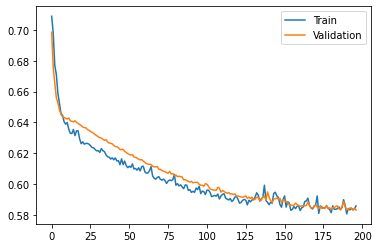

In [395]:
import matplotlib.pyplot as plt

plt.plot(training_loss[3:], label="Train")
plt.plot(validation_loss[3:], label="Validation")
plt.legend()

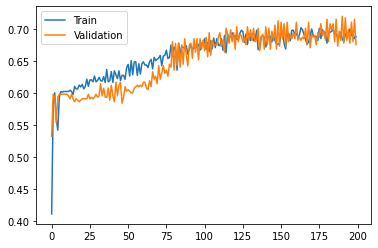

In [393]:
plt.plot(training_acc, label="Train")
plt.plot(validation_acc, label="Validation")
plt.legend()

# Tabela modela
[in, 20, 1], lr = 3e-4 | ACC : <69
[in, 20, 4, 1], lr = 3e-4 | ACC : 72%

In [394]:
max(validation_acc)

0.719626168224299